# STAT 551
# Man Chong (Henry) Leong
# Vignette 1 - Spatial dependence and visualization for polygon level data - of House Hold Income in Harris County

## Goal

Living in Houston, we all know that there are some segregations for residents with different economic statuses. For example, people making more money will live in the areas of which the housing price is higher, and vice versa.

Can we make sure whether this phenomenon exists? This question can be answered by using some methods in spatial statistics.


First of all, the census dataset we are going to use is from https://www.kinderudp.org/.

Thanks to the R community, there are plenty of R packages that we can use for spatial statistics. For example, "rgdal", "spdep" are widely used for the connection between GIS and R; "gstat" provides a lot of useful functions for spatial statistics and "ggplot2" is not only popular in the statistics world, but also very useful for visualizing spatial data. 

In [1]:
rm(list=ls())
library("rgdal")
library("dplyr")
library("data.table")
library("gstat")
library("tidyr")
library("spgwr")
library("spdep")
library("ggplot2")

# read datasets
censusData_bg <- data.table::fread("/Users/manchongleong/Desktop/STAT551/Curated/Cen2010Harris_BG_v01.csv",
                    colClasses = c(GeoID10_bg="chatacher",
                                   stfips="character",
                                   county="character",
                                   tract="character")) %>%
  dplyr::rename(GEOID10=GeoID10_bg)
# read census boundary
censusBoundary <- rgdal::readOGR(dsn="/Users/manchongleong/Desktop/STAT551/", 
                          layer="tl_2010_48_bg10")
# only get the records in Harris County
censusBoundary.harris <- censusBoundary[grepl(c("201"),
                                      censusBoundary@data$COUNTYFP10), ]

# merge boundary with census data
censusBoundary.harris <- censusBoundary.harris %>%
  merge(censusData_bg, by = "GEOID10")


Loading required package: sp
rgdal: version: 1.3-2, (SVN revision 755)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: /Library/Frameworks/R.framework/Versions/3.5/Resources/library/rgdal/proj
 Linking to sp version: 1.3-1 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

Loading required package: spData
To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge

OGR data source with driver: ESRI Shapefile 
Source: "/Users/manchongleong/Desktop/STAT551", layer: "tl_2010_48_bg10"
with 15811 features
It has 15 fields
Integer64 fields read as strings:  OBJECTID 


The dataset we are using here is 2010 census data in blockgroup level.

First of all, we need to import the shapefile if we want to map the data. For details about shapefile and spatial join in R, please take a look at my presentation in class:
https://github.com/HenryLeongStat/STAT551/blob/master/spatial_join_in_R.ipynb

After importing the shapefile, we need to subset the blockgroups only in harris county.

Subsetting data before doing spatial merge is recommended because it is faster and more memory-efficient than doing spatial merge with the whole boundary data.

In [2]:
censusBoundary.harris@data$id <- rownames(censusBoundary.harris@data)

# remove na
censusBoundary.harris_clean <- censusBoundary.harris[
    !(is.na(censusBoundary.harris@data$MedHHinc)), ]

# might have outliers, create another dataset without outlier
# outside 1.5 times the interquartile 
# range above the upper quartile and bellow the lower quartile
censusBoundary.harris_clean_rm_ol <- censusBoundary.harris_clean[
    !(censusBoundary.harris_clean@data$MedHHinc %in% 
      boxplot(censusBoundary.harris_clean@data$MedHHinc, 
              plot=FALSE)$out), ]


In spatial statistics, same rules from statistics in other fields should applied. For example, outliers might or might not affact the analysis.

In this vignette, the effect of outliers will be shown. 

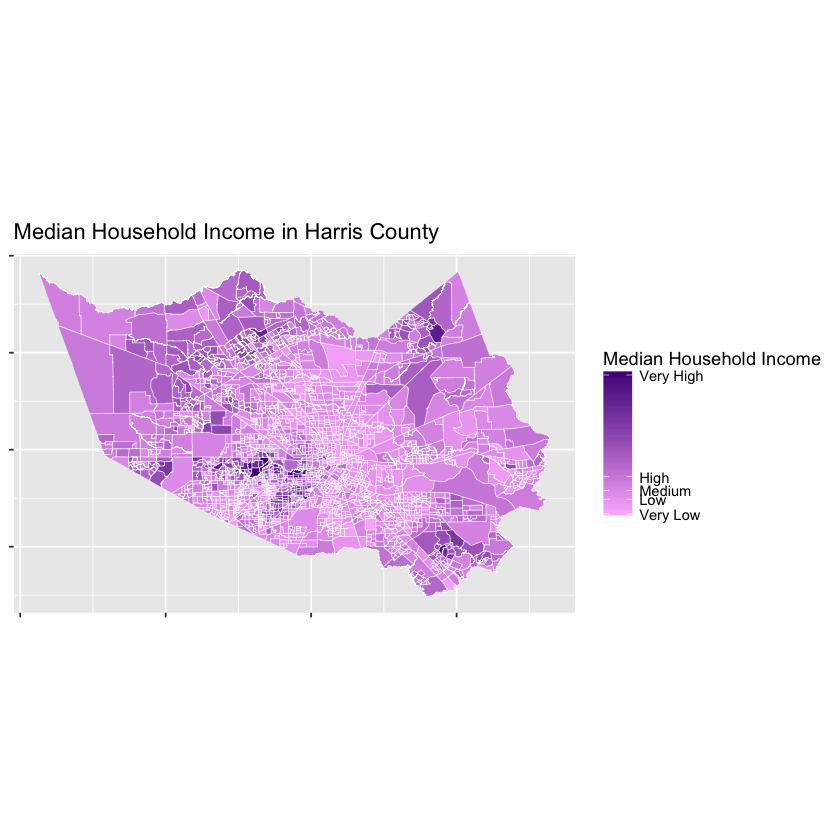

In [3]:
# convert a spatial object into data.frame
HarrisCty.tidy <- ggplot2::fortify(censusBoundary.harris_clean, 
                                   region="id")

HarrisCty.tidy_merge <- merge(HarrisCty.tidy, censusBoundary.harris_clean@data, 
                              by="id")

map_HarrisCty <- ggplot(data=HarrisCty.tidy_merge, 
                        aes(long,lat,group=group,fill=MedHHinc)) + 
  geom_polygon() +
  geom_path(color = "white", 
            size=0.1) +
  scale_fill_gradient(low = "plum1", 
                      high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                     labels=c("Very Low", "Low", "Medium", "High", "Very High")) +
  coord_equal() +
  theme(axis.title = element_blank(), 
        axis.text = element_blank()) +
  labs(title = "Median Household Income in Harris County", 
       fill = "Median Household Income")

map_HarrisCty

"ggplot2" is an awesome tool for visualizing spatial data, and it is very fexible for mapping spatial data.

As the map shown above, except for couple blockgroups, the colors of the others are so light! Seems like the Median Household income in those outliers are far higher than the others. When it comes to map, sometimes outliers will greatly affect the colors of the map. If the "value" that we are interested in the outliers are too large, and then it can blur the patterns of the spatial data.

We can check whether there are any outliers with boxplot.

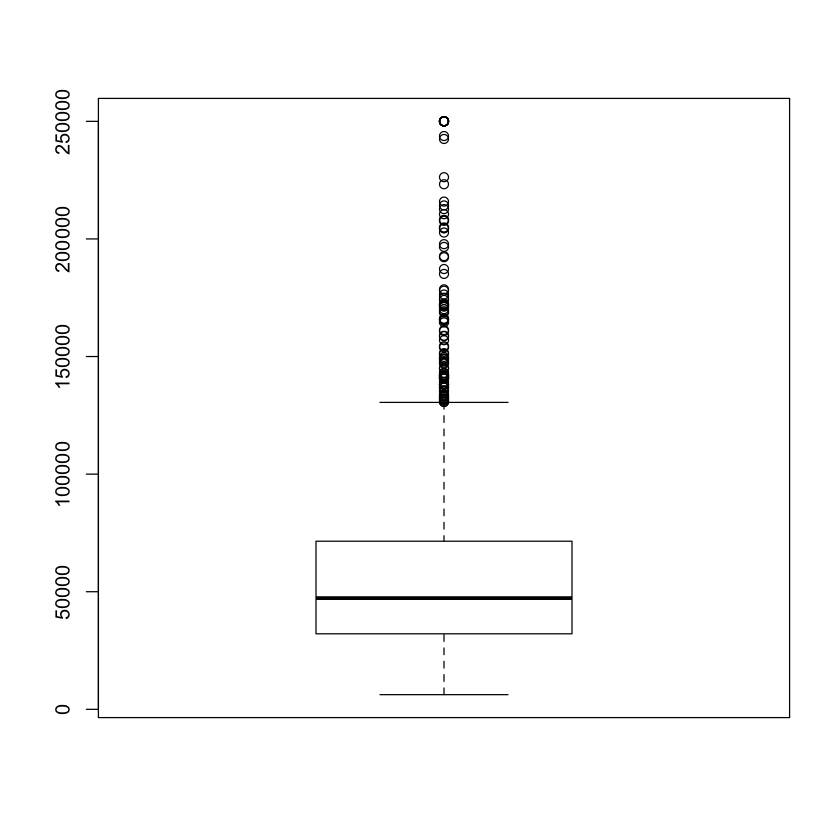

In [4]:
boxplot(censusBoundary.harris_clean@data$MedHHinc)

It seems we should deal with the outliers if we want to see some other patterns in the map.

What happens if we remove the outliers and make the map again?

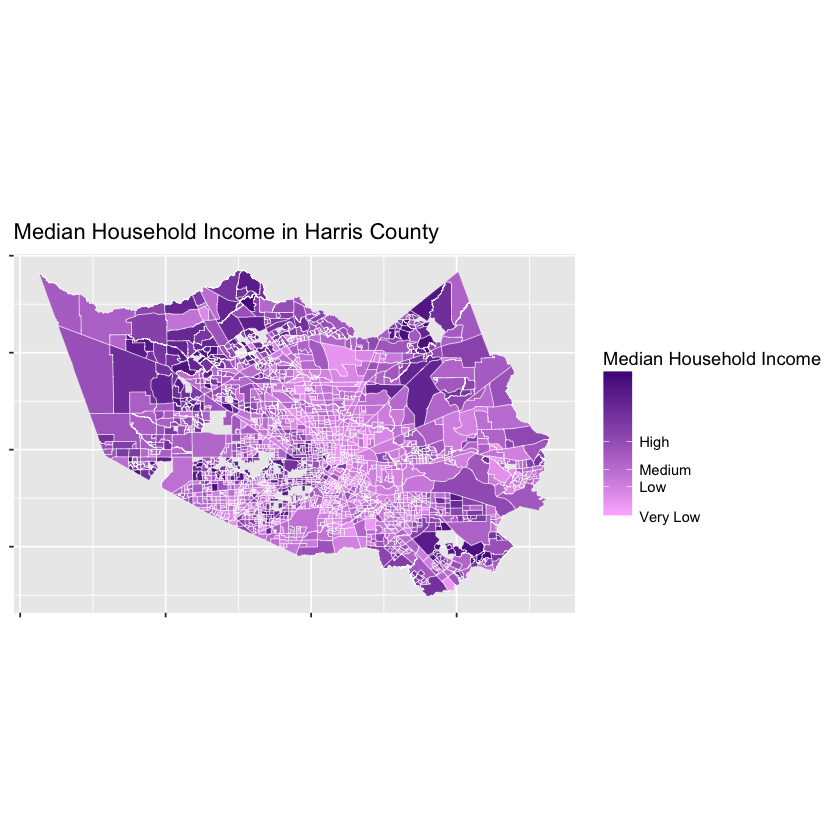

In [5]:
# convert a spatial object into data.frame
HarrisCty.tidy_rm_ot <- ggplot2::fortify(censusBoundary.harris_clean_rm_ol, 
                                         region="id")

HarrisCty.tidy_rm_ot_merge <- merge(HarrisCty.tidy_rm_ot, 
                                    censusBoundary.harris_clean_rm_ol@data, 
                                    by="id")

map_HarrisCty_rm_ot_merge <- ggplot(data=HarrisCty.tidy_rm_ot_merge, 
                                    aes(long,
                                        lat,
                                        group = group,
                                        fill = MedHHinc)) + 
  geom_polygon() +
  geom_path(color = "white", 
            size=0.1) +
  scale_fill_gradient(low = "plum1", 
                      high = "purple4", 
                      breaks = quantile(censusBoundary.harris_clean@data$MedHHinc),
                      labels = c("Very Low", "Low", "Medium", "High", "Very High")) +
  coord_equal() +
  theme(axis.title = element_blank(), 
        axis.text = element_blank()) +
  labs(title = "Median Household Income in Harris County", 
       fill = "Median Household Income")

map_HarrisCty_rm_ot_merge

Here, we are using the same breaks (note: not the same break for color!) for the two maps. The "high" value becomes much higher in the second plot.

The map looks more colorful after removing outliers! Also, some patterns are clearly shown from the map. For example, it clearly shows that the income of those people living in the northern west to higher than the people living in the middle north, while we cannot get the same information from the first map which is blurred by the outliers. 


## Using Variogram to check spatial patterns

For spatial data, it is very difficult to sample data with a continuous scale. For example, temperature data is usually sampled at some specific points, and it is not practical to build a lot of data sampling points close to each others. In this case, interpolation is very useful if we want to "guess" the actual value from a location where we don't have any sample.

Before going to the discussion of interpolation, variogram is a basic knowledge for that, and very important for spatial statistics.

The example below is going to show how to visualize a variogram and see whether it is isotropic.

Also, will outliers affect variogram? If the answer is yes, how large it will affect the variogram?

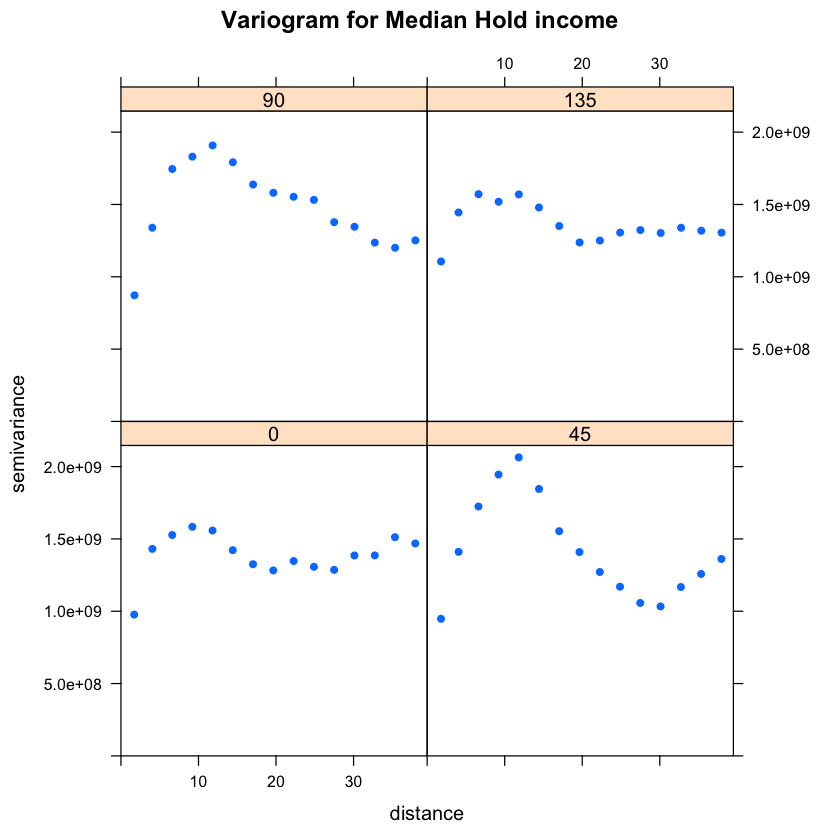

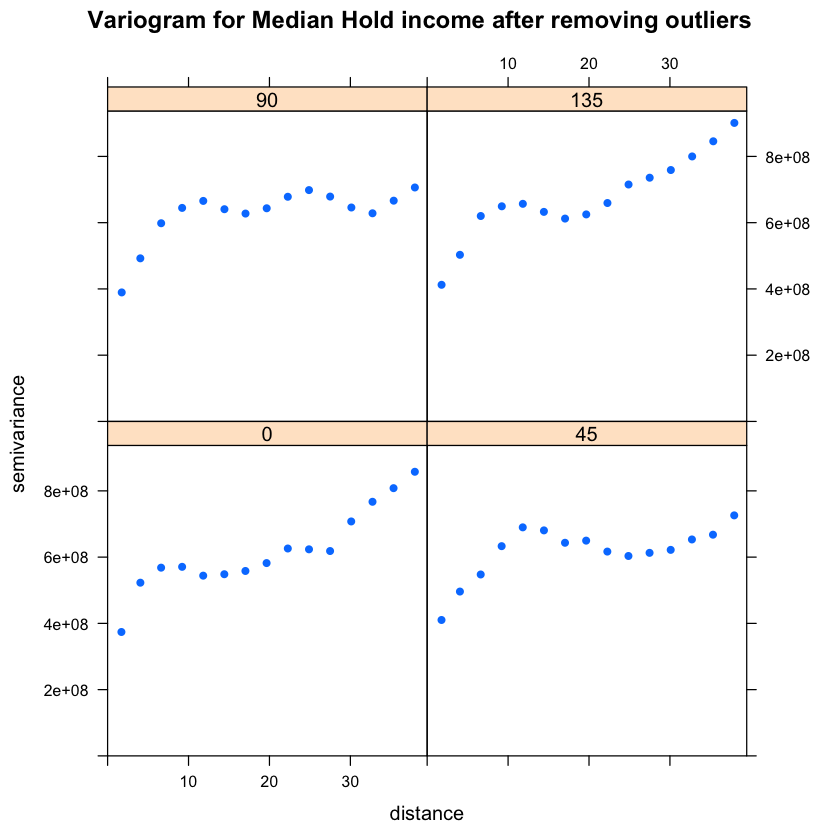

In [6]:
## variogram 
harris_vgm <- gstat::variogram(MedHHinc~1, 
                               censusBoundary.harris_clean, 
                               alpha = c(0, 45, 90, 135))
harris_vgm_rm_ol <- gstat::variogram(MedHHinc~1, 
                                     censusBoundary.harris_clean_rm_ol, 
                                     alpha = c(0, 45, 90, 135))

plot(harris_vgm, 
     main = "Variogram for Median Hold income", 
     pch = 16)
plot(harris_vgm_rm_ol, 
     main = "Variogram for Median Hold income after removing outliers", 
     pch = 16)



Checking for anisotropy, we change direction in plane (x,y) in positive (0, 45, 90, 135) degrees clockwise from positive y (North). Obviously, direction in plane (x,y) actually matters for variogram of Median Household Income. Also, after removing outliers, the variogram changes a lot!

As we can see in the Y-axis, the scale is very large. Would the variogram change rapidly if we change the scale?

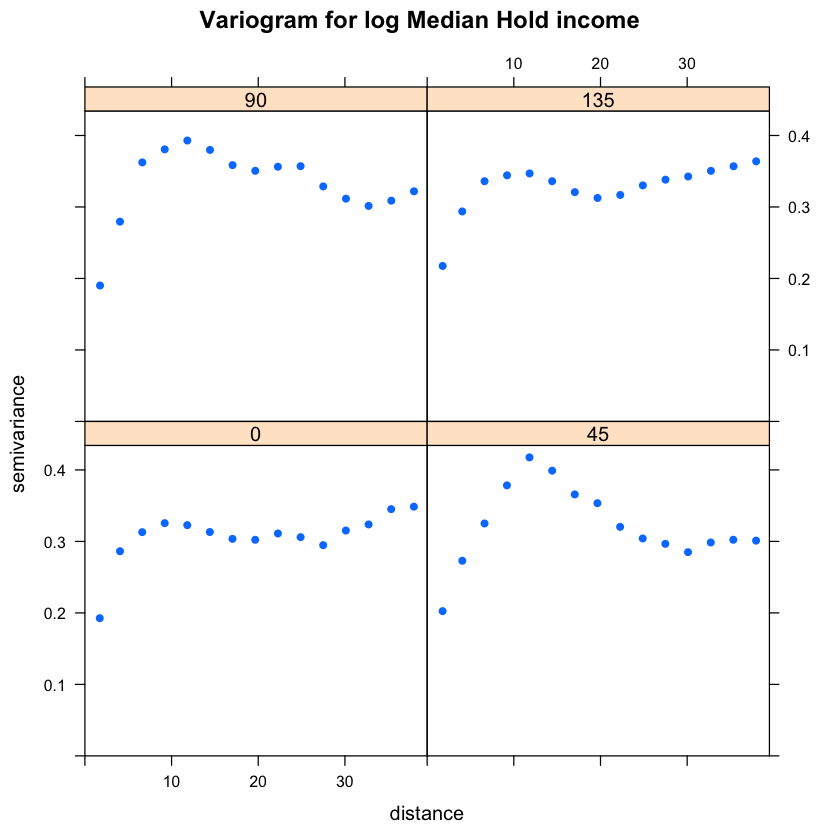

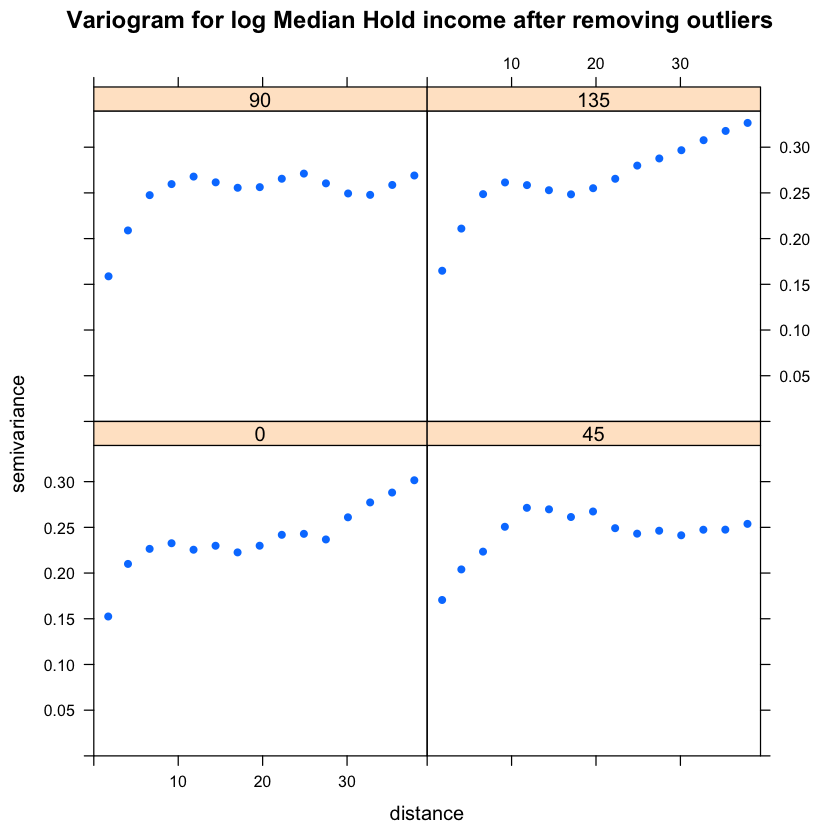

In [7]:
## variogram 
harris_vgm <- gstat::variogram(log(MedHHinc)~1, 
                               censusBoundary.harris_clean, 
                               alpha = c(0, 45, 90, 135))
harris_vgm_rm_ol <- gstat::variogram(log(MedHHinc)~1, 
                                     censusBoundary.harris_clean_rm_ol, 
                                     alpha = c(0, 45, 90, 135))

#census_grid <- sp::spsample(x=censusBoundary, bb=bbox_census, 10000, type="regular")
#plot(MedHHinc_vgm_cloud, main = "Variogram Cloud for MedHHinc", pch = 16)

#Hisp_vgm <- gstat::variogram(Hisp~long+lat, censusBoundary.harris)
plot(harris_vgm, 
     main = "Variogram for log Median Hold income", pch = 16)
plot(harris_vgm_rm_ol, 
     main = "Variogram for log Median Hold income after removing outliers", pch = 16)



Changing the scale, the shapes do change a little bit. Based on these plots, after removing outliers, the spatial patterns are easiest to interpret with changing direction in plane (x,y) in positive 45 or 90 degrees clockwise from positive y (North).

## Statistical tests for spatial dependence

Using Moran I test and Geary C test, we can test whether the observations are spatially independent or not. 

H0: There is no spatial clustering of the values associated with the geographic features.

H1: There is spatial clustering of the values associated with the geographic features.

In [9]:
censusBoundary_nb <- spdep::poly2nb(censusBoundary.harris_clean)
censusBoundary_listw <- spdep::nb2listw(censusBoundary_nb, 
                                        style = "W", 
                                        zero.policy=T)

spdep::moran.test(censusBoundary.harris_clean@data$MedHHinc, 
           censusBoundary_listw, 
           zero.policy = T) 
spdep::geary.test(censusBoundary.harris_clean@data$MedHHinc, 
           censusBoundary_listw, 
           zero.policy = T) 


	Moran I test under randomisation

data:  censusBoundary.harris_clean@data$MedHHinc  
weights: censusBoundary_listw    

Moran I statistic standard deviate = 46.284, p-value < 2.2e-16
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.5694741594     -0.0004672897      0.0001516355 



	Geary C test under randomisation

data:  censusBoundary.harris_clean@data$MedHHinc 
weights: censusBoundary_listw 

Geary C statistic standard deviate = 34.139, p-value < 2.2e-16
alternative hypothesis: Expectation greater than statistic
sample estimates:
Geary C statistic       Expectation          Variance 
     0.4338633382      1.0000000000      0.0002750045 


Both Moran I test and Geary C test show that there are strong evidences to show that there is spatial clustering of the values associated with the geographic features.

## Modelling using Kriging

We already know how to use and interpret variogram, and we found that there are spatial effects in the data. The next step is modeling. 

Same as statistics in other fields, spatial statistical modeling can be used for prediction. With a corrected spatial statistical model, it helps us to get a good interpolation.

In [72]:
# using "grid" as new data
bbox_census <- sp::bbox(censusBoundary.harris_clean_rm_ol)
census_grid <- sp::spsample(x=censusBoundary.harris_clean_rm_ol,
                            bb=bbox_census, 10000, type="regular")
gridded(census_grid) <- TRUE  # Create SpatialPixel object
fullgrid(census_grid) <- TRUE  # Create SpatialGrid object
proj4string(census_grid) <- proj4string(censusBoundary.harris)


  model     psill    range
1   Sph 0.2369033 3.537678


  model     psill    range
1   Exp 0.2494511 1.775872


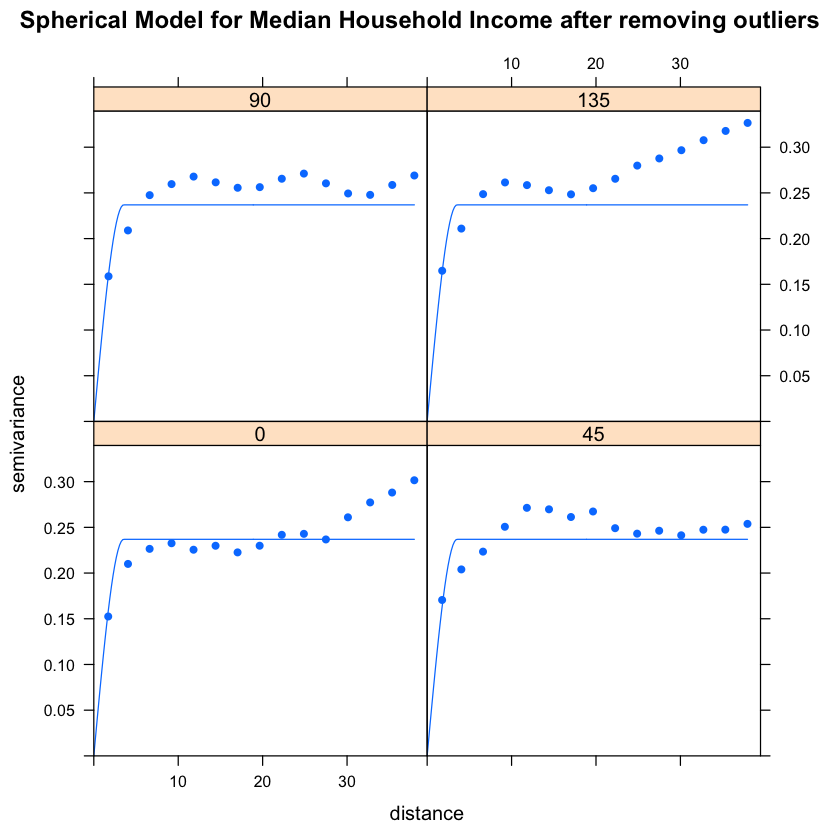

ERROR: Error in cbind(newdata@bbox[cbind(c(1, 1, 1, 1), c(1, 2, 1, 1))], newdata@bbox[cbind(c(2, : object 'census_grid' not found


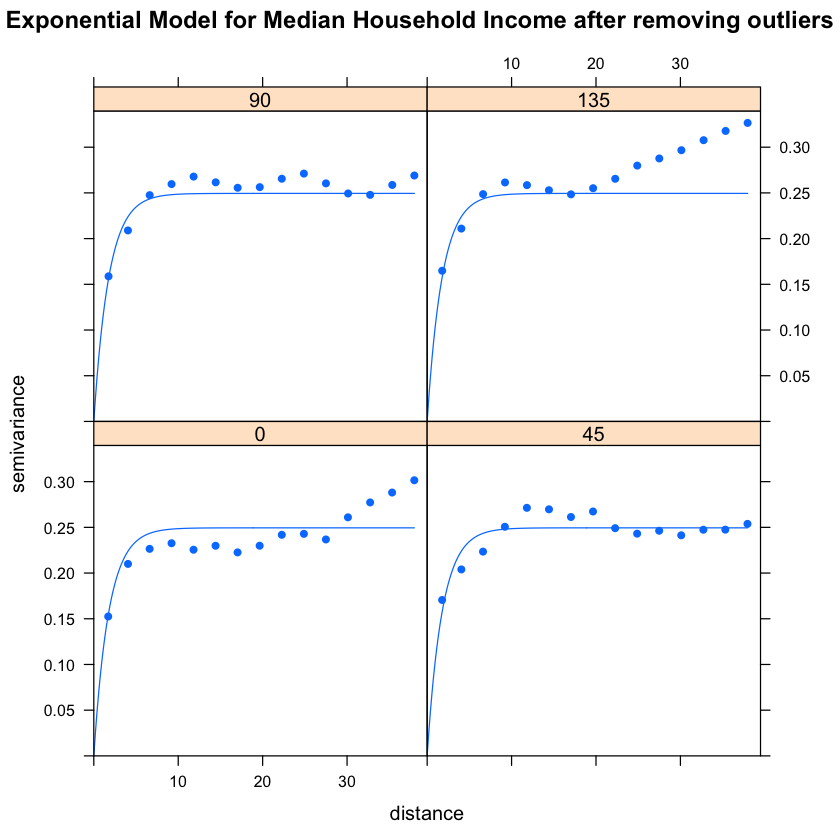

In [10]:
# spherical
mmhi_fit_sph <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                      model = gstat::vgm(model =  "Sph"))
print(mmhi_fit_sph)
plot(harris_vgm_rm_ol, 
     mmhi_fit_sph, 
     main = "Spherical Model for Median Household Income after removing outliers", 
     pch = 16)

# exponential
mmhi_vgm_exp <- gstat::fit.variogram(harris_vgm_rm_ol, 
                                     model = gstat::vgm(model =  "Exp"))
print(mmhi_vgm_exp)
plot(harris_vgm_rm_ol, 
     mmhi_vgm_exp, 
     main = "Exponential Model for Median Household Income after removing outliers", 
     pch = 16)

# spherical
mmhi_krig_sph <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_fit_sph)

# exponential
mmhi_krig_exp <- gstat::krige(MedHHinc~1, 
                              censusBoundary.harris_clean_rm_ol, 
                              census_grid, 
                              model = mmhi_vgm_exp)




Using ordinary kriging, fitting model with changing direction in plane (x,y) in positive 45 or 90 degrees clockwise from positive y (North) seems to be the best.

# Reference

United States Census Bureau, & Children’s Environmental Health Initiative. (2016). American Community Survey (ACS) 2010 data for Harris County, Texas, USA (Version 1) [Data set]. Rice University-Kinder Institute: UDP. https://doi.org/10.25612/837.8koe0a2ka4qb

SoS Notebook: An Interactive Multi-Language Data Analysis Environment. Bo Peng, Gao Wang, Jun Ma, Man Chong Leong, Chris Wakefield, James Melott, Yulun Chiu, Di Du, and John N. Weinstein, Bioinformatics, May 2018. doi: https://doi.org/10.1093/bioinformatics/bty405

Using R — Working with Geospatial Data (and ggplot2). Bethany Yollin http://mazamascience.com/WorkingWithData/?p=1494

How Spatial Autocorrelation: Moran's I (Spatial Statistics) works http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_tools/how_spatial_autocorrelation_colon_moran_s_i_spatial_statistics_works.htm

Notes and code example from STAT 551.